In [68]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [69]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, Dropout, GaussianNoise, BatchNormalization, UpSampling2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [70]:
'mnist' in tfds.list_builders()

True

# Loading data and preprocessing

In [71]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

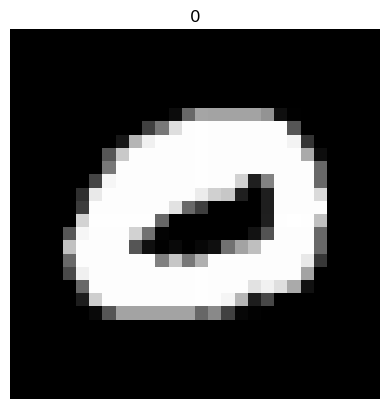

In [72]:
import numpy as np
# Datapreprocessing
x_train = x_train.reshape((60_000, 28, 28, 1))
x_test = x_test.reshape((10_000, 28, 28, 1))

# Normalizing the values
x_train = x_train.astype(np.float64)/255.0
x_test = x_test.astype(np.float64)/255.0

idx = np.random.randint(0,60_000)
plt.imshow(x_train[idx, :, :, :], cmap='gray')
plt.title(y_train[idx])
plt.axis('off')
plt.show()


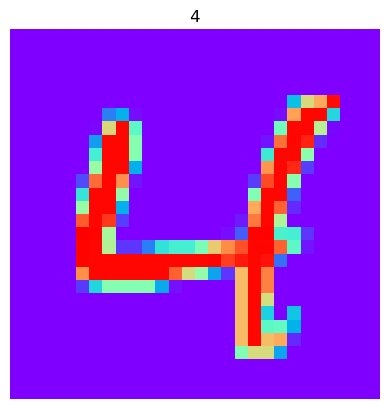

In [73]:
idx = np.random.randint(0,60_000)
plt.imshow(x_train[idx, :, :, :], cmap='rainbow')
plt.title(y_train[idx])
plt.axis('off')
plt.show()

# Change dataset into something easy to process using tensorflow

In [190]:
batch_size = 512

# Prepare the training dataset
# Need only images, not labels
# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset
# test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Make a Generator and Discriminator model

In [95]:
def make_generator():
    input_noise = Input(128, name='Noise-input')
    x = Dense(128*2, activation='relu')(input_noise)
    x = BatchNormalization()(x)
    x = Dense(128*8, activation='relu')(x)
    x = Dense(784, activation='sigmoid')(x)
    output_img = Reshape((28,28,1))(x)
    model = Model(inputs = [input_noise], outputs = [output_img], name="Generator-model")
    return model

In [96]:
# generator = make_generator()
# generator.summary()

In [97]:
def make_discriminator():
    input_image = Input((28, 28, 1), name='Image-input')
#     x = GaussianNoise(0.5)(input_image)
    x = Conv2D(64, (3,3), activation='relu')(input_image)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(32, (3,3), activation="relu")(x)
    x = MaxPooling2D((2,2))(x) #new
    x = Flatten()(x)
    x = Dense(200, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation="softmax")(x) # classify real or fake
    model = Model(inputs=[input_image], outputs=[output], name="Discriminator-model")
    return model

In [98]:
# discriminator = make_discriminator()
# discriminator.summary()

# Testing the generator

In [99]:
# noise_in = tf.random.normal((4, 128), seed=32)

# gen_ = generator(noise_in)

# for i in range(4):
#     plt.subplot(2, 2, i+1)
#     plt.imshow(gen_[i], cmap='gray')
#     plt.axis('off')
# #     plt.title(i+1)
# plt.suptitle("Generated images before training")
# plt.show()

# Defining the GAN class

In [181]:
class MyGan(Model):
    def __init__(self, generator_nn, discriminator_nn):
        super().__init__()
        self.generator = generator_nn
        self.discriminator = discriminator_nn
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile the parent class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 
        
    def train_step(self, batch):
        real_data = batch
        noise_ = tf.random.normal((512,128,1)) # noise to generate image
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            gen_data = self.generator(noise_, training=True)
            
#         # make data to train the discriminator
#         real_data = batch
#         noise_ = tf.random.normal((1,128,1)) # noise to generate image
#         gen_data = self.generator(noise_, training=False)
# #         all_data = tf.concat([real_data, gen_data], axis=0) 
# #         y = tf.concat([tf.zeros(real_data.shape[0]), tf.ones(gen_data.shape[0])], axis=0) # make true labels
        
#         # Train Discriminator; Track gradients
#         with tf.GradientTape() as d_tape:
#             y_hat_0 = self.discriminator(real_data, training=True) # Make prediction
#             y_hat_1 = self.discriminator(gen_data, training=True) # Make prediction
#             y_hat = tf.concat([y_hat_0, y_hat_1], axis=0) # All predictions
#             y = tf.concat([tf.zeros_like(y_hat_0), tf.ones_like(y_hat_1)], axis=0) # True labels; [real, fake]
#             all_d_loss = self.d_loss(y, y_hat) # Compute loss
#         d_gradients = d_tape.gradient(all_d_loss, self.discriminator.trainable_variables) # Compute gradients
#         self.d_opt.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables)) #Apply gradients
            
#         # Train Generator; Track gradients
#         with tf.GradientTape() as g_tape:
# #             noise_ = tf.random.normal(batch[0].shape)
#             gen_images = self.generator(noise_, training=True) # generate images
#             pred = self.discriminator(gen_images, training=False) # pass through discriminator
#             all_g_loss = self.g_loss(tf.zeros_like(pred), pred) # discriminator needs to be fooled
# #             all_g_loss = self.g_loss(tf.ones_like(pred), pred) # experimenting
#         g_gradients = g_tape.gradient(all_g_loss, self.generator.trainable_variables) # Compute gradients
#         self.g_opt.apply_gradients(zip(g_gradients, self.generator.trainable_variables)) # Apply gradients
        
#         return {"d_loss": all_d_loss, "g_loss":all_g_loss}
# #     @tf.function
#     def train_gan(self, dataset, epochs):
#         for epoch in range(epochs):
#             d_running_loss = []
#             g_running_loss = []
#             for batch in dataset:
#                 losses = self.train_step(batch)
#                 d_running_loss.append(losses["d_loss"])
#                 g_running_loss.append(losses["g_loss"])  
#             print(f"Epoch: {epoch+1}, d_loss: {sum(d_running_loss)/len(d_running_loss): .4f}, g_loss: {sum(g_running_loss)/len(g_running_loss): .4f}")

In [182]:
generator_optimizer = Adam(learning_rate=0.0001)
discriminator_optimizer = Adam(learning_rate=0.00001)
generator_loss = BinaryCrossentropy() # can also use BinaryCrossentropy
discriminator_loss = BinaryCrossentropy() # can also use BinaryCrossentropy

In [183]:
generator = make_generator()
discriminator = make_discriminator()

mnist_gan = MyGan(generator, discriminator)

In [184]:
mnist_gan.generator.summary()
print()
print()
mnist_gan.discriminator.summary()


Model: "Generator-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Noise-input (InputLayer)    [(None, 128)]             0         
                                                                 
 dense_78 (Dense)            (None, 256)               33024     
                                                                 
 batch_normalization_16 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_79 (Dense)            (None, 1024)              263168    
                                                                 
 dense_80 (Dense)            (None, 784)               803600    
                                                                 
 reshape_16 (Reshape)        (None, 28, 28, 1)         0         
                                                   

In [185]:
mnist_gan.compile(generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss)

In [188]:
hist = mnist_gan.train_gan(train_dataset, epochs=20)

Epoch: 1, d_loss:  15.3181, g_loss:  0.6214
Epoch: 2, d_loss:  15.3181, g_loss:  0.6204
Epoch: 3, d_loss:  15.3181, g_loss:  0.6194
Epoch: 4, d_loss:  15.3181, g_loss:  0.6185
Epoch: 5, d_loss:  15.3181, g_loss:  0.6175
Epoch: 6, d_loss:  15.3181, g_loss:  0.6166
Epoch: 7, d_loss:  15.3181, g_loss:  0.6156
Epoch: 8, d_loss:  15.3181, g_loss:  0.6147
Epoch: 9, d_loss:  15.3181, g_loss:  0.6137
Epoch: 10, d_loss:  15.3181, g_loss:  0.6128
Epoch: 11, d_loss:  15.3181, g_loss:  0.6119
Epoch: 12, d_loss:  15.3181, g_loss:  0.6109
Epoch: 13, d_loss:  15.3181, g_loss:  0.6100
Epoch: 14, d_loss:  15.3181, g_loss:  0.6091
Epoch: 15, d_loss:  15.3181, g_loss:  0.6082
Epoch: 16, d_loss:  15.3181, g_loss:  0.6073
Epoch: 17, d_loss:  15.3181, g_loss:  0.6064
Epoch: 18, d_loss:  15.3181, g_loss:  0.6055
Epoch: 19, d_loss:  15.3181, g_loss:  0.6046
Epoch: 20, d_loss:  15.3181, g_loss:  0.6037


# Testing generator for improvement

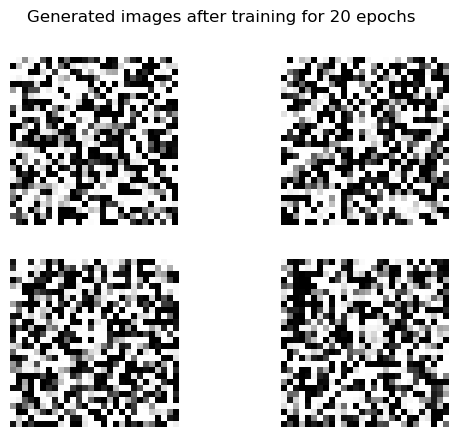

In [189]:
noise_in = tf.random.normal((4, 128), seed=32)

gen_ = generator(noise_in)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(gen_[i], cmap='gray')
    plt.axis('off')
#     plt.title(i+1)
plt.suptitle("Generated images after training for 20 epochs")
plt.show()

# Trying something else

In [133]:
generator = make_generator()
generator.summary()
print()
print()
discriminator = make_discriminator()
discriminator.summary()

Model: "Generator-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Noise-input (InputLayer)    [(None, 128)]             0         
                                                                 
 dense_43 (Dense)            (None, 256)               33024     
                                                                 
 batch_normalization_9 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_44 (Dense)            (None, 1024)              263168    
                                                                 
 dense_45 (Dense)            (None, 784)               803600    
                                                                 
 reshape_9 (Reshape)         (None, 28, 28, 1)         0         
                                                   

In [134]:
noise_ = tf.random.normal((60_000, 128))
gen_img = generator(noise_)
gen_img.shape

TensorShape([60000, 28, 28, 1])

In [135]:
dis_train = tf.concat([x_train, gen_img], axis=0)
dis_train.shape

TensorShape([120000, 28, 28, 1])

In [136]:
labels = tf.concat([tf.zeros((60_000,)), tf.ones((60_000,))], axis=0)
labels.shape

TensorShape([120000])

In [155]:
optimizer = Adam(learning_rate=0.001)
loss = BinaryCrossentropy()
discriminator.compile(loss=loss, optimizer=optimizer)
hist = discriminator.fit(dis_train, labels, batch_size=1024, epochs=5, 
                         validation_split=0.0)

Epoch 1/5
118/118 [==============================] - 6s 38ms/step - loss: 0.0301
Epoch 2/5
118/118 [==============================] - 5s 40ms/step - loss: 6.8095e-05
Epoch 3/5
118/118 [==============================] - 5s 40ms/step - loss: 1.5801e-05
Epoch 4/5
118/118 [==============================] - 5s 42ms/step - loss: 9.4544e-06
Epoch 5/5
118/118 [==============================] - 5s 43ms/step - loss: 3.4075e-06


In [138]:
discriminator.evaluate(dis_train, labels)

3750/3750 [==============================] - 15s 4ms/step - loss: 2.4426e-07


2.4425756350865413e-07